# Lump vs. No Lump ADC Data Comparison

This notebook allows you to compare the mean and standard deviation of ADC values for 'LUMP' and 'NO_LUMP' conditions based on a specified weight, sensor name, and trial number. This helps in quickly assessing the impact of the 'lump' on sensor readings under specific experimental setups.

## 1. Setup and Data Loading

First, we'll import the necessary libraries and load all cleaned ADC data. We'll also define a function to parse the metadata from the filenames.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob

# Configure seaborn for better aesthetics
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

def parse_filename(filepath):
    """Parses the filename to extract metadata."""
    basename = os.path.basename(filepath)
    match = re.match(r'clean_ADC_([\d\.]+)g_([A-Z])_trial(\d+)_(NO_)?(LUMP)_raw_.*\.csv', basename)
    if match:
        weight = float(match.group(1))
        sensor = match.group(2)
        trial = int(match.group(3))
        lump_status = 'NO_LUMP' if match.group(4) else 'LUMP'
        return {'weight': weight, 'sensor': sensor, 'trial': trial, 'lump_status': lump_status}
    
    match_base = re.match(r'clean_ADC_raw_.*\.csv', basename)
    if match_base:
        return {'weight': 0.0, 'sensor': 'Unknown', 'trial': 0, 'lump_status': 'Unknown'}
    
    return None

all_cleaned_files = glob.glob('hta/**/clean_ADC_*.csv', recursive=True)

data_records = []
for fpath in all_cleaned_files:
    metadata = parse_filename(fpath)
    if metadata:
        try:
            df_adc = pd.read_csv(fpath)
            if 'ADC' in df_adc.columns:
                metadata['mean_adc'] = df_adc['ADC'].mean()
                metadata['std_dev_adc'] = df_adc['ADC'].std()
                metadata['file_path'] = fpath
                metadata['raw_data'] = df_adc['ADC'].tolist() # Store raw data for plotting
                data_records.append(metadata)
            else:
                print(f"Warning: 'ADC' column not found in {fpath}")
        except Exception as e:
            print(f"Error reading {fpath}: {e}")

df_summary = pd.DataFrame(data_records)
print(f"Loaded {len(df_summary)} records.")


Loaded 23 records.


## 2. Input Parameters and Comparison

Enter the desired `weight`, `sensor` (e.g., 'B' or 'D'), and `trial` number below to see the comparison.

**Available Weights:** 

Available Weights: [np.float64(847.23), np.float64(2159.64)]
Available Sensors: ['B', 'D']
Available Trials: [np.int64(1), np.int64(2), np.int64(3)]
Comparing for: Weight=847.23g, Sensor=B, Trial=2
Results ---
LUMP Condition (Mean ADC): 2885.64
LUMP Condition (Std Dev ADC): 1.94
NO_LUMP Condition (Mean ADC): 2703.61
NO_LUMP Condition (Std Dev ADC): 2.84


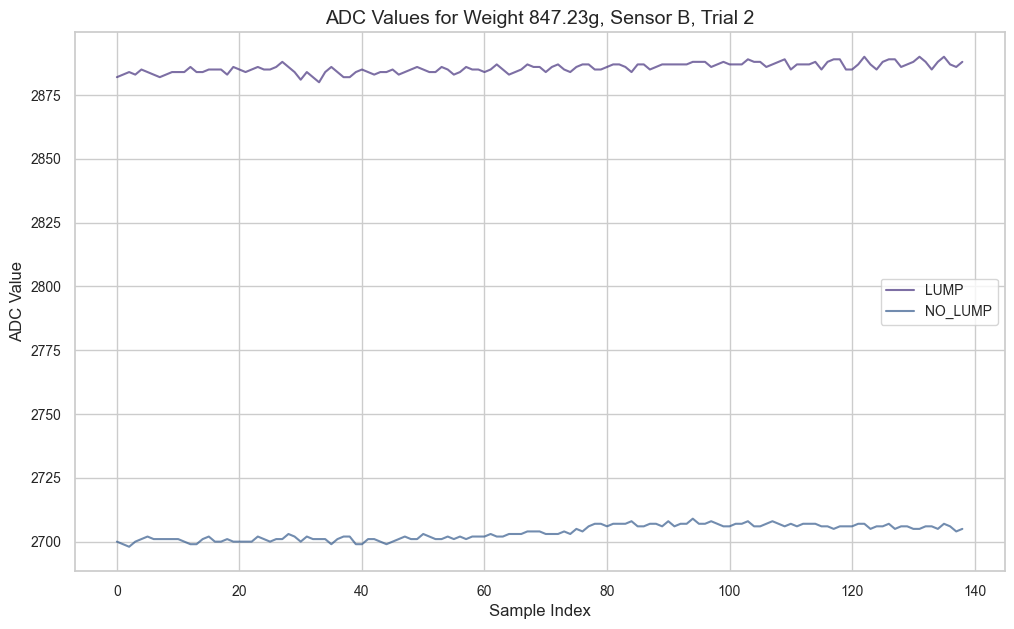

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_78602/3768297320.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Condition', y='Mean ADC', data=df_plot, palette='coolwarm')


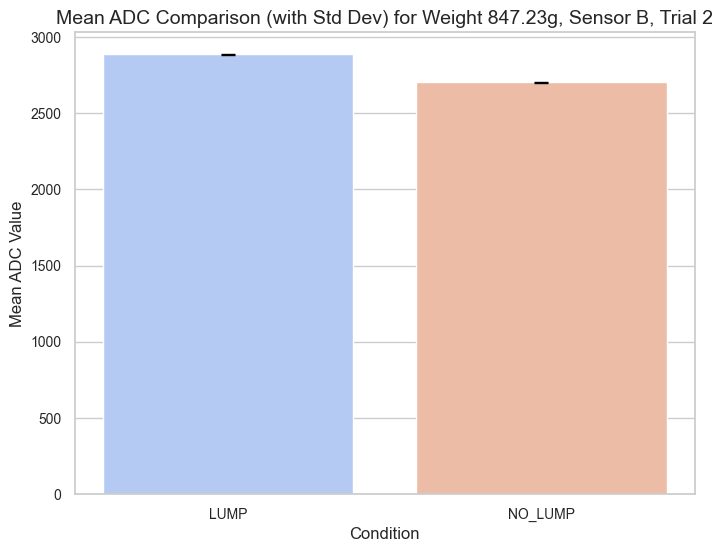

In [3]:
# Display available unique values for user guidance
print("Available Weights:", sorted(df_summary['weight'].unique()))
print("Available Sensors:", sorted(df_summary['sensor'].unique()))
print("Available Trials:", sorted(df_summary['trial'].unique()))

# --- USER INPUT --- 
# Modify these values to select your desired experiment
selected_weight = 847.23  # Example: 847.23, 2159.64
selected_sensor = 'B'   # Example: 'B', 'D'
selected_trial = 2      # Example: 1, 2, 3
# ------------------

print(f"Comparing for: Weight={selected_weight}g, Sensor={selected_sensor}, Trial={selected_trial}")

filtered_data = df_summary[
    (df_summary['weight'] == selected_weight) &
    (df_summary['sensor'] == selected_sensor) &
    (df_summary['trial'] == selected_trial)
].copy() # Use .copy() to avoid SettingWithCopyWarning

if filtered_data.empty:
    print("No data found for the selected criteria. Please check your inputs.")
else:
    lump_data = filtered_data[filtered_data['lump_status'] == 'LUMP']
    no_lump_data = filtered_data[filtered_data['lump_status'] == 'NO_LUMP']

    print("Results ---")
    if not lump_data.empty:
        print(f"LUMP Condition (Mean ADC): {lump_data['mean_adc'].iloc[0]:.2f}")
        print(f"LUMP Condition (Std Dev ADC): {lump_data['std_dev_adc'].iloc[0]:.2f}")
    else:
        print("LUMP Condition: No data found.")

    if not no_lump_data.empty:
        print(f"NO_LUMP Condition (Mean ADC): {no_lump_data['mean_adc'].iloc[0]:.2f}")
        print(f"NO_LUMP Condition (Std Dev ADC): {no_lump_data['std_dev_adc'].iloc[0]:.2f}")
    else:
        print("NO_LUMP Condition: No data found.")

    # Visualization of raw data for comparison
    plt.figure(figsize=(12, 7))
    if not lump_data.empty:
        plt.plot(lump_data['raw_data'].iloc[0], label='LUMP', alpha=0.7)
    if not no_lump_data.empty:
        plt.plot(no_lump_data['raw_data'].iloc[0], label='NO_LUMP', alpha=0.7)

    if not lump_data.empty or not no_lump_data.empty:
        plt.title(f'ADC Values for Weight {selected_weight}g, Sensor {selected_sensor}, Trial {selected_trial}')
        plt.xlabel('Sample Index')
        plt.ylabel('ADC Value')
        plt.legend()
        plt.show()
    else:
        print("No raw data to plot for the selected criteria.")

    # Bar plot for mean ADC comparison
    plot_data = []
    if not lump_data.empty: plot_data.append({'Condition': 'LUMP', 'Mean ADC': lump_data['mean_adc'].iloc[0], 'Std Dev ADC': lump_data['std_dev_adc'].iloc[0]})
    if not no_lump_data.empty: plot_data.append({'Condition': 'NO_LUMP', 'Mean ADC': no_lump_data['mean_adc'].iloc[0], 'Std Dev ADC': no_lump_data['std_dev_adc'].iloc[0]})
    
    if plot_data:
        df_plot = pd.DataFrame(plot_data)
        plt.figure(figsize=(8, 6))
        sns.barplot(x='Condition', y='Mean ADC', data=df_plot, palette='coolwarm')
        plt.errorbar(x=df_plot['Condition'], y=df_plot['Mean ADC'], yerr=df_plot['Std Dev ADC'], fmt='none', c='black', capsize=5)
        plt.title(f'Mean ADC Comparison (with Std Dev) for Weight {selected_weight}g, Sensor {selected_sensor}, Trial {selected_trial}')
        plt.ylabel('Mean ADC Value')
        plt.show()
